# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
print('Done')

Done


# Dataset exploration

In [2]:
#Let's explore the directory segmentation
os.listdir('/kaggle/input/siim-isic-melanoma-classification')

['train.csv',
 'train',
 'tfrecords',
 'jpeg',
 'test.csv',
 'test',
 'sample_submission.csv']

In [3]:
#How many training images do we have?
len(os.listdir('/kaggle/input/siim-isic-melanoma-classification/jpeg/train'))

33126

In [4]:
#How many test images do we have?
len(os.listdir('/kaggle/input/siim-isic-melanoma-classification/jpeg/test'))

10982

In [5]:
train_metadata = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
train_metadata.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
#Dataset length
len(train_metadata)

33126

In [7]:
#Sex segmentation
male = train_metadata[train_metadata['sex']=='male']['sex'].count()
female = train_metadata[train_metadata['sex']=='female']['sex'].count()
print('The number of male patients: ',male)
print('The number of female patients: ',female)

The number of male patients:  17080
The number of female patients:  15981


In [8]:
benign = train_metadata[train_metadata['benign_malignant']=='benign']['benign_malignant'].count()
malignant = train_metadata[train_metadata['benign_malignant']=='malignant']['benign_malignant'].count()
print('The number of benign cases: ',benign)
print('The number of malign cases: ',malignant)

The number of benign cases:  32542
The number of malign cases:  584


In [9]:
#We will definitely will need to augment the malignant cases

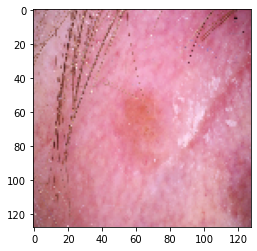

In [10]:
#Let's explore some images - Let's study a benign case

%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = image.astype('float32')
image /= 255.0
plt.imshow(image)
plt.show()

In [11]:
train_metadata[train_metadata['benign_malignant']=='malignant'].head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


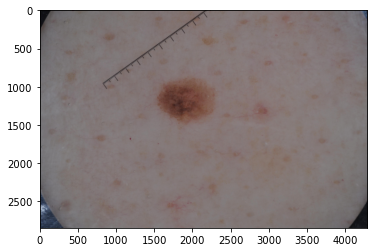

In [12]:
#Let's explore a malignant case
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0232101.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (128, 128))
plt.imshow(image)
plt.show()

In [13]:
#Is there any relationship between age/anatom site and diagnosis?
train_metadata['anatom_site_general_challenge'].unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso', nan,
       'palms/soles', 'oral/genital'], dtype=object)

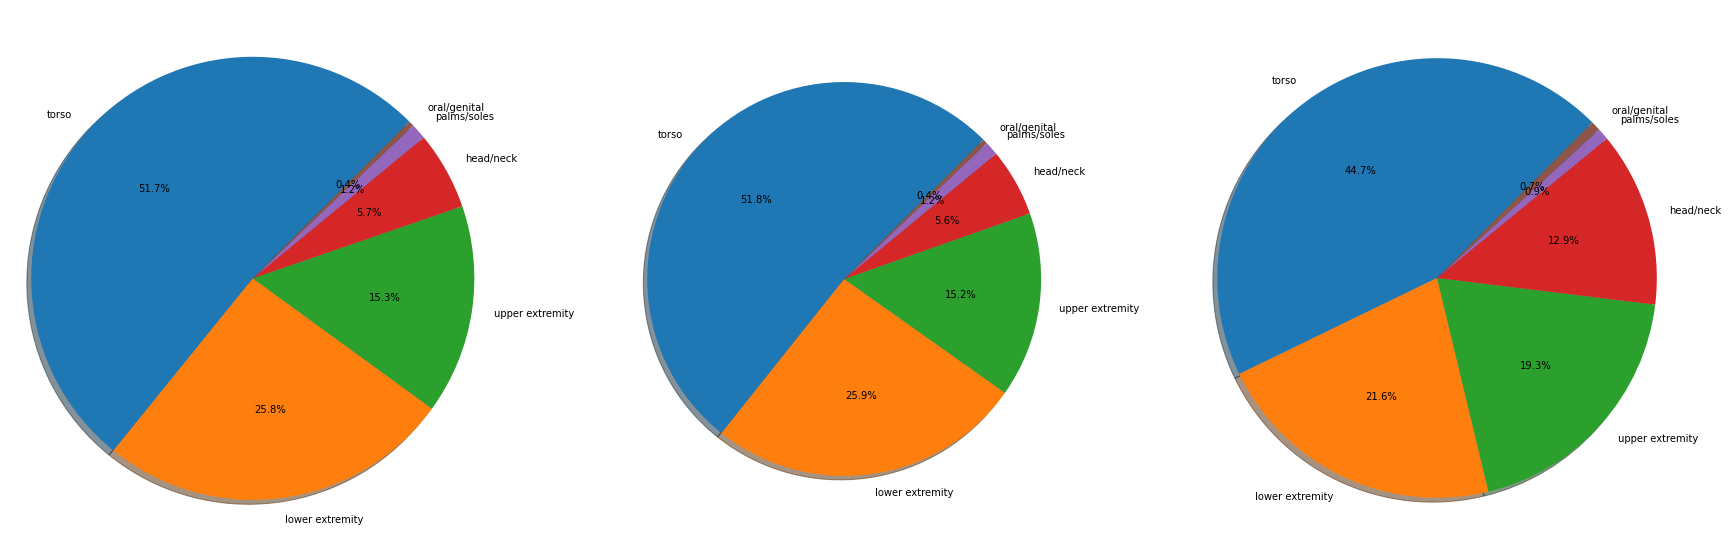

In [14]:
#Is there any particular lesion location more abundant than others?

%matplotlib inline
plt.figure(figsize=(30,10))

ax1 = plt.subplot(131)
labels1 = list(train_metadata['anatom_site_general_challenge'].value_counts().index.values)
sizes1 = list(train_metadata['anatom_site_general_challenge'].value_counts().values)
explode1 = (0, 0.1, 0, 0)
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2 = plt.subplot(132)
labels2 = list(train_metadata[train_metadata['benign_malignant']=='benign']['anatom_site_general_challenge'].value_counts().index.values)
sizes2 = list(train_metadata[train_metadata['benign_malignant']=='benign']['anatom_site_general_challenge'].value_counts().values)
explode2 = (0, 0.1, 0, 0)
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax3 = plt.subplot(133)
labels3 = list(train_metadata[train_metadata['benign_malignant']=='malignant']['anatom_site_general_challenge'].value_counts().index.values)
sizes3 = list(train_metadata[train_metadata['benign_malignant']=='malignant']['anatom_site_general_challenge'].value_counts().values)
explode3 = (0, 0.1, 0, 0)
ax3.pie(sizes3, labels=labels3, autopct='%1.1f%%',shadow=True, startangle=45)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
#Looks like all lesion images have same amount proportion, so locations should not be a relevant factor. Let's study age.

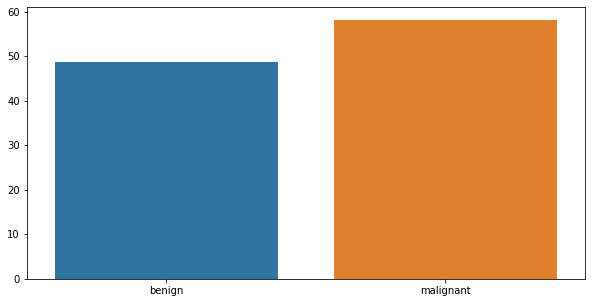

In [16]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10,5))
sex = ['benign','malignant']
values = [train_metadata[train_metadata['benign_malignant']=='benign']['age_approx'].mean(),train_metadata[train_metadata['benign_malignant']=='malignant']['age_approx'].mean()]
sns.barplot(sex,values)
plt.show()

In [17]:
#Looks like age is an important feature. We'll see if consider this is crucial when predicting labels for each case.

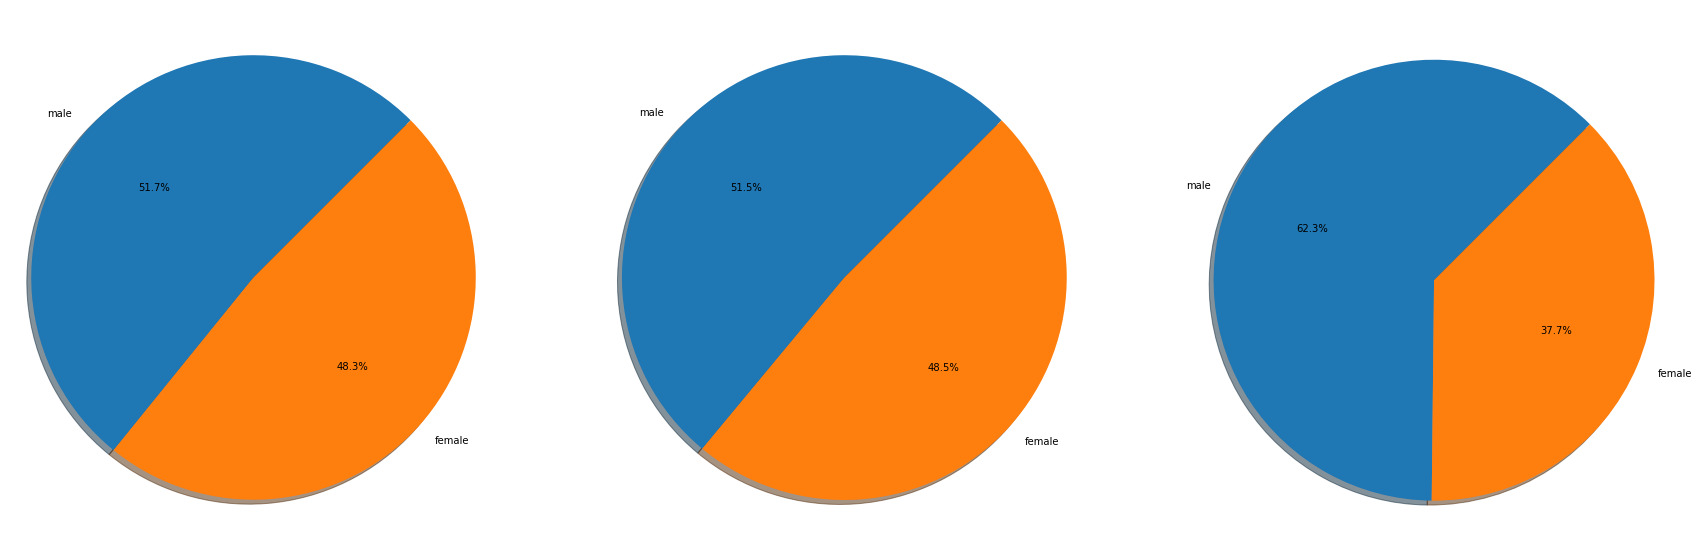

In [18]:
#What about sex?

#Is there any particular lesion location more abundant than others?

%matplotlib inline
plt.figure(figsize=(30,10))

ax1 = plt.subplot(131)
labels1 = list(train_metadata['sex'].value_counts().index.values)
sizes1 = list(train_metadata['sex'].value_counts().values)
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%',shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2 = plt.subplot(132)
labels2 = list(train_metadata[train_metadata['benign_malignant']=='benign']['sex'].value_counts().index.values)
sizes2 = list(train_metadata[train_metadata['benign_malignant']=='benign']['sex'].value_counts().values)
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%',shadow=True, startangle=45)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax3 = plt.subplot(133)
labels3 = list(train_metadata[train_metadata['benign_malignant']=='malignant']['sex'].value_counts().index.values)
sizes3 = list(train_metadata[train_metadata['benign_malignant']=='malignant']['sex'].value_counts().values)
ax3.pie(sizes3, labels=labels3, autopct='%1.1f%%',shadow=True, startangle=45)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [19]:
#Looks like case is also different but when talking about malignant cases.

# Image preprocessing

In [20]:
#We will reshape every image to 128*128 pixels

def data_augmentation(dirname,filename):
    
    """
    This function will perform data augmentation: 
    for each one of the images, will create shifted, expanded/reduced, darker/lighter, rotated images. 5 for every modification type. 
    In total, we will create 20 extra images for every one in the original dataset.
    """
    
    image_data = []
    #reading the image
    image = cv2.imread(os.path.join(dirname, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    #expanding the image dimension to one sample
    samples = expand_dims(image, 0)
    # creating the image data augmentation generators
    datagen1 = ImageDataGenerator(width_shift_range=[-10,10])
    datagen2 = ImageDataGenerator(zoom_range=[0.7,1.2])
    datagen3 = ImageDataGenerator(brightness_range=[0.2,1.1])
    datagen4 = ImageDataGenerator(rotation_range=20)
    # preparing iterators
    it1 = datagen1.flow(samples, batch_size=1)
    it2 = datagen2.flow(samples, batch_size=1)
    it3 = datagen3.flow(samples, batch_size=1)
    it4 = datagen4.flow(samples, batch_size=1)
    image_data.append(image)
    for i in range(5):
        # generating batch of images
        batch1 = it1.next()
        batch2 = it2.next()
        batch3 = it3.next()
        batch4 = it4.next()
        # convert to unsigned integers
        image1 = batch1[0].astype('uint8')
        image2 = batch2[0].astype('uint8')
        image3 = batch3[0].astype('uint8')
        image4 = batch4[0].astype('uint8')
        #appending to the list of images
        image_data.append(image1)
        image_data.append(image2)
        image_data.append(image3)
        image_data.append(image4)
        
    return image_data

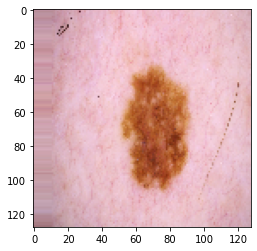

In [21]:
#Let's test our function.
result = data_augmentation('/kaggle/input/siim-isic-melanoma-classification/jpeg/train','ISIC_0207268.jpg')
#Let's plot an image
%matplotlib inline
plt.figure()
image = result[5]
plt.imshow(image)
plt.show()

In [22]:
len(result)

21

In [23]:
def data_transformation(case_type):
    
    """
    This function receives a keyword as parameter to determine the kind of set it's going to process.
    It uses data_augmentation function to expand the image quantity, then resizes the images and finally returns a list containing the images already processed.
    IMPORTANT: Maybe you'll notice we don't use any Keras method which could make easier the image processing. Instead, we decided to process the images using our own functions.
    """
    
    images = []
    dirname = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
    counter = 0
    
    if case_type ==0: # If we need to transform malignant images
        
        image_names = train_metadata[train_metadata['benign_malignant']=='malignant']['image_name'].reset_index(drop=True)+'.jpg'
    
        for i in range(len(image_names)):
            filename = image_names[i]
            image = cv2.imread(os.path.join(dirname, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            images.append(image)
            counter += 1
        for i in range(len(image_names)):
            filename = image_names[i]
            result = data_augmentation(dirname,filename)
            for i in range(len(result)):
                if i==0: #If the image is the one used to augmentate the dataset, then continue bc it has been appended already
                    continue
                else:
                    images.append(result[i])
                    counter += 1  
    
    if case_type ==1: #If we need to transform benign images (only reshape)
        
        images = []
        image_names = train_metadata[train_metadata['benign_malignant']=='benign']['image_name'][:10000].reset_index(drop=True)+'.jpg'
        
        for i in range(len(image_names)):
            filename = image_names[i]
            image = cv2.imread(os.path.join(dirname, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            images.append(image)
            
    return images

In [24]:
malignant_images = data_transformation(0)[:10000] #Let's transform all malignant images
print('Done')

Done


In [25]:
gc.collect()

17689

In [26]:
malignant_images[0].shape

(128, 128, 3)

In [27]:
len(malignant_images)

10000

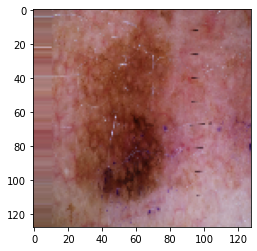

In [28]:
%matplotlib inline
plt.figure()
image = malignant_images[900]
plt.imshow(image)
plt.show()

In [29]:
benign_images = data_transformation(1) #Let's transform all benign images
print('Done')

Done


In [30]:
len(benign_images)

10000

In [31]:
gc.collect()

2507

# Dataset splitting

In [32]:
#Now we need to create our training/testing dataset
y = []
for i in range(10000):
    #Appending benign labels
    y.append(0)
for i in range(10000):
    #Appending benign labels
    y.append(1)
len(y)

20000

In [33]:
X = benign_images + malignant_images
X = np.array(X)
type(X)

numpy.ndarray

In [34]:
X[0]

array([[[182, 144, 158],
        [130,  85,  82],
        [183, 133, 144],
        ...,
        [146,  63,  89],
        [144,  64,  89],
        [136,  61,  83]],

       [[168, 126, 132],
        [156, 103, 111],
        [180, 127, 145],
        ...,
        [156,  80, 106],
        [153,  73, 105],
        [143,  70,  95]],

       [[179, 128, 140],
        [163, 114, 120],
        [166, 116, 124],
        ...,
        [155,  75, 104],
        [153,  75, 101],
        [146,  74,  96]],

       ...,

       [[144,  89,  95],
        [146,  92,  98],
        [166, 115, 130],
        ...,
        [155,  95, 105],
        [152,  90, 106],
        [136,  73,  92]],

       [[147,  90, 102],
        [144,  87,  95],
        [152,  93, 105],
        ...,
        [158,  94, 110],
        [149,  89, 101],
        [138,  77,  92]],

       [[143,  87,  94],
        [140,  83,  89],
        [143,  84,  87],
        ...,
        [157,  95, 110],
        [140,  73,  90],
        [137,  78,  96]]

In [35]:
! mkdir train

In [36]:
! mkdir images

In [37]:
cv2.imwrite('train/'+str(0)+'.JPEG', cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

True

In [38]:
for i in range(len(X)):
    cv2.imwrite('train/'+str(i)+'.JPEG', cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
print('Done')

Done


In [39]:
y = np.array(y)
type(y)

numpy.ndarray

In [40]:
gc.collect()

180

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0,shuffle=True)

# Model building

In [42]:
#batch_size = 50
#from keras.preprocessing.image import ImageDataGenerator
#datagen = ImageDataGenerator(rescale=1./255)
#train_generator = datagen.flow(X_train,y_train,batch_size=batch_size)
#test_generator = datagen.flow(X_test,y_test,batch_size=batch_size)

In [43]:
img_shape = (128,128,3)

In [44]:
X_train[0].shape

(128, 128, 3)

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7)) #Because the model was overfitting, so I'm forcing it to learn more meaningful patters in the data
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       5

# Model compilation

In [47]:
#Training the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc']) # I had to avoid the default LR because it was getting stuck in a local minima.

# Model training

In [48]:
history = model.fit(X_train, y_train, epochs=36,validation_data=(X_test, y_test)) #Using this way because the dataset is not big enough to train by batches
#history = model.fit_generator(train_generator, steps_per_epoch=ntrain//50,epochs=30,validation_data=test_generator,validation_steps=ntest//50)

Epoch 1/36
469/469 [==============================] - 12s 25ms/step - loss: 0.7257 - acc: 0.5965 - val_loss: 0.6022 - val_acc: 0.6804
Epoch 2/36
469/469 [==============================] - 11s 24ms/step - loss: 0.5940 - acc: 0.6777 - val_loss: 0.4933 - val_acc: 0.7546
Epoch 3/36
469/469 [==============================] - 11s 24ms/step - loss: 0.5253 - acc: 0.7370 - val_loss: 0.4434 - val_acc: 0.8158
Epoch 4/36
469/469 [==============================] - 11s 24ms/step - loss: 0.4638 - acc: 0.7796 - val_loss: 0.3829 - val_acc: 0.8326
Epoch 5/36
469/469 [==============================] - 11s 24ms/step - loss: 0.4224 - acc: 0.8017 - val_loss: 0.4572 - val_acc: 0.7808
Epoch 6/36
469/469 [==============================] - 11s 24ms/step - loss: 0.3820 - acc: 0.8291 - val_loss: 0.3205 - val_acc: 0.8638
Epoch 7/36
469/469 [==============================] - 11s 24ms/step - loss: 0.3600 - acc: 0.8365 - val_loss: 0.3158 - val_acc: 0.8620
Epoch 8/36
469/469 [==============================] - 11s 24ms

# Model evaluation

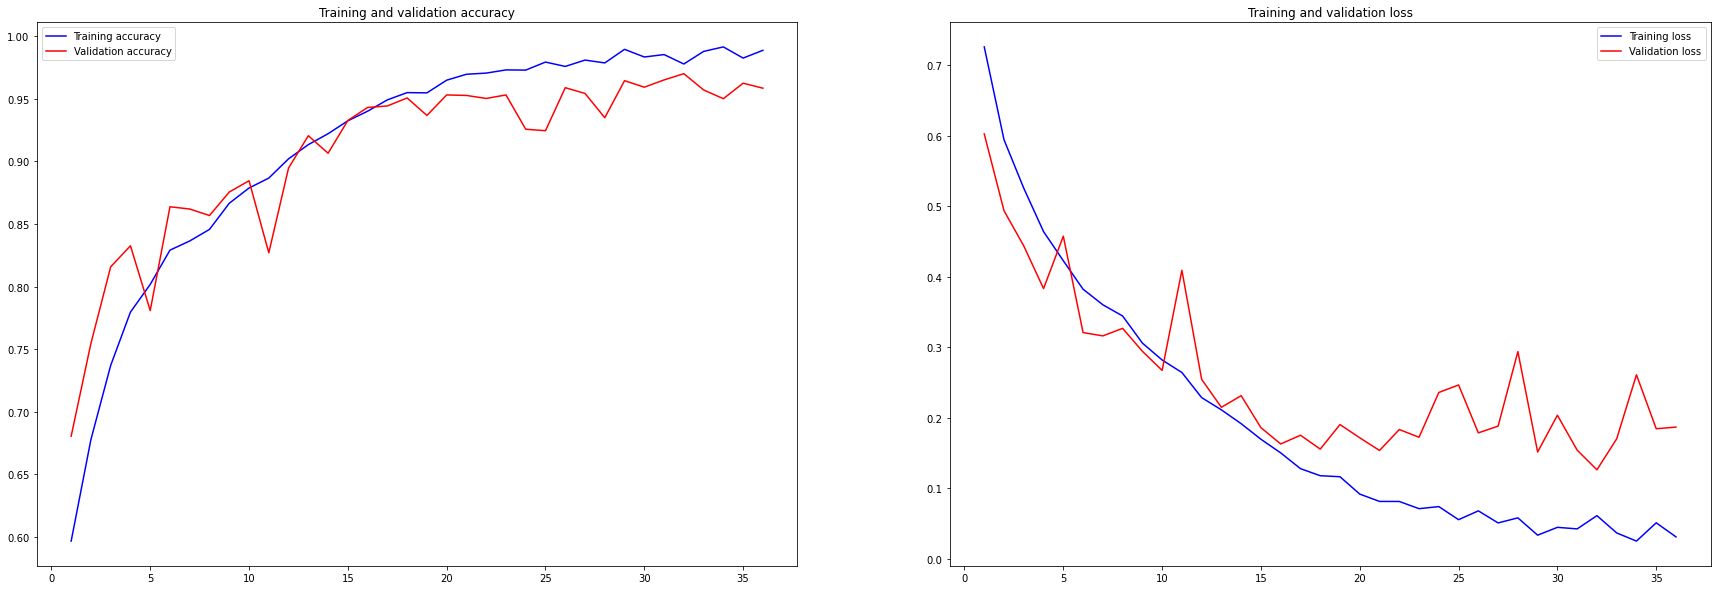

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)


%matplotlib inline
plt.figure(figsize=(30,10))

ax1 = plt.subplot(121)
ax1.plot(epochs,acc,'b',label='Training accuracy')
ax1.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
ax1.legend()

ax2 = plt.subplot(122)
ax2.plot(epochs,loss,'b',label='Training loss')
ax2.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
ax2.legend()

plt.show()

In [50]:
#test_loss, test_acc = model.evaluate_generator(test_generator, steps=ntest//50, verbose=2)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 1s - loss: 0.1864 - acc: 0.9586
Model accuracy:  0.9585999846458435


## This is a very good number! let's see what the confusion matrix shows.

# Model validation

In [51]:
y_pred = model.predict(X_test)

# Saving the model

In [52]:
model.save("CNN_Melanoma.h5")  # Saving the model to reload it in the future

In [53]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))

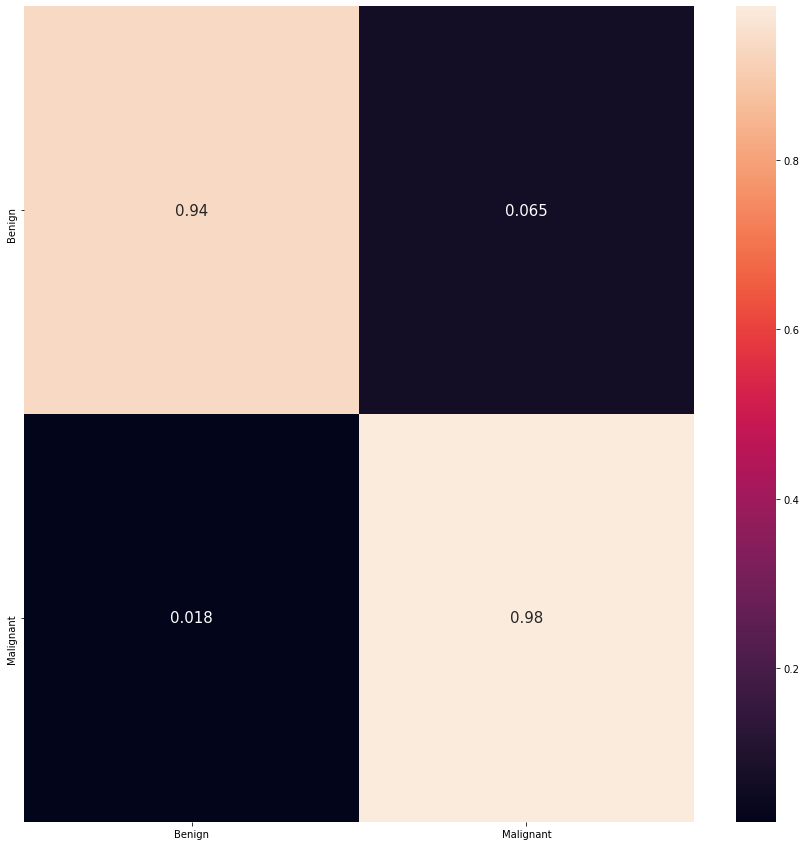

In [54]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Benign','Malignant'],columns = ['Benign','Malignant'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Fantastic! It's reaching very good score for both classes, the recall must be very high when developing models for the medical field so let's see what it shows.

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.around(y_pred, decimals=0)))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2477
           1       0.94      0.98      0.96      2523

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



# Conclusions
Alright, we've reached the end of this notebook, but there are a few things to highlight though. First of all, even when the dataset is really small the model reached a very good metric. To get even higher metrics we have to get more data - in this particular notebook we couldn't use more due to RAM issues, but in more powerful notebook instances it wouldn't be a problem. Another good approach would be to implement even more regularization and train for much more epochs, but the model tuning depends on every ML requirement, generally it's a long process all of us have different methods to go through.

Thanks for reading!